In [1]:
import numpy as np
import pandas as pd
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

import anndata

from scipy.stats import pearsonr, ranksums

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
ct = group_name

In [5]:
indir = '/data/female-amb/scDomain/'
res = 25000

In [6]:
sc_border = anndata.read_h5ad(f'{ct}_cell_boundary.h5ad')
sc_border

AnnData object with n_obs × n_vars = 927 × 98520
    obs: 'AgingMajorType', 'Age', 'Replicate', 'AgingMajorType.Age'
    var: 'chrom', 'start', 'end'

In [7]:
def compute_domain_size(i):
    global res, sc_border
    tmp = sc_border.raw.X[i]
    tmp = np.repeat(tmp.indices, tmp.data).reshape((-1, 2))
    return (tmp[:, 1] - tmp[:, 0]).sum() * res

In [8]:
meta_file = '/data/metadata/240104_m3C_META.csv'
metadata = pd.read_csv(meta_file, index_col = 0)
metadata['AgingMajorType'] = metadata['AgingMajorType'].apply(lambda x: x.replace(' ','_').replace('/',''))
metadata = metadata[['AgingMajorType','Age','Replicate']]

In [9]:
metadata= metadata.loc[sc_border.obs_names]

In [10]:
ncpu = 20
domain_size, cell_list = [], []
with ProcessPoolExecutor(ncpu) as exe:
    future_dict = {}
    for i,cell in enumerate(metadata.index):
        future = exe.submit(compute_domain_size, i=i)
        future_dict[future] = cell

    for future in as_completed(future_dict):
        cell = future_dict[future]
        # print(f'{cell} finished.')
        domain_size.append(future.result())
        cell_list.append(cell)

In [11]:
domain_size = pd.Series(domain_size, index=cell_list)
metadata['domain_coverage'] = domain_size.copy()
metadata.loc[sc_border.obs.index, 'domain_count'] = sc_border.raw.X.sum(axis=1).A1 / 2

In [12]:
# sc_border.X.data = np.ones(sc_border.X.data.shape)
metadata.loc[sc_border.obs.index, 'boundary_count'] = sc_border.raw.X.getnnz(axis=1)

In [13]:
metadata['domain_size'] = metadata['domain_coverage'] / metadata['domain_count']

In [14]:
metadata['AgingMajorType.Age'] = metadata['AgingMajorType'].astype(str) + '.' + metadata['Age'].astype(str)

In [16]:
leg = [f"{ct}.{age}" for age in ['8wk','9mo','18mo']]
leg

['Astro-NT_NN.8wk', 'Astro-NT_NN.9mo', 'Astro-NT_NN.18mo']

In [19]:
ranksums(metadata.loc[metadata['Age'].isin(['8wk']), 'domain_count'], 
         metadata.loc[metadata['Age'].isin(['18mo']), 'domain_count'])

RanksumsResult(statistic=-2.586192686960601, pvalue=0.009704266369984572)

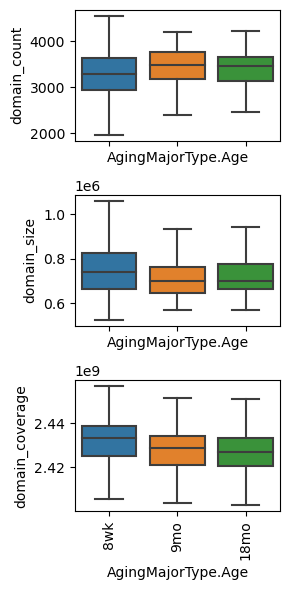

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(3,6), sharex='all', dpi=100)
ax = axes[0]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_count', order=leg, showfliers=False, ax=ax)
ax = axes[1]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_size', order=leg, showfliers=False, ax=ax)
ax = axes[2]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_coverage', order=leg, showfliers=False, ax=ax)
ax.set_xticklabels(['8wk','9mo','18mo'],rotation=90)
plt.tight_layout()
# plt.savefig(f'cell_{sc_border.shape[0]}_majortype_domain_boxplot.pdf', transparent=True, dpi=300)